In [462]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score

In [463]:
import pandas as pd

# Cargar el conjunto de datos desde un archivo CSV
data_path = r"C:\Proyectos programación\Modelos\consumo_casa.csv"
data = pd.read_csv(data_path)

# Eliminar la primera columna (asumiendo que se llama 'Unnamed: 0')
data.drop(columns=['Unnamed: 0'], inplace=True)

# Convertir la columna 'Fecha' a tipo datetime si no lo está
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Dividir la columna 'Fecha' en mes, día, hora y minuto
data['Mes'] = data['Fecha'].dt.month
data['Dia'] = data['Fecha'].dt.day
data['Hora'] = data['Fecha'].dt.hour
data['Minuto'] = data['Fecha'].dt.minute

# Agregar una nueva columna para el día de la semana en formato de texto
data['Dia_semana'] = data['Fecha'].dt.day_name()

# Convertir la columna 'Dia_semana' en variables dummy
data = pd.get_dummies(data, columns=['Dia_semana'])

data.drop(columns=['Fecha'], inplace=True)

print(data.columns)


Index(['Medidor [W]', 'Refrigerator', 'Clothes washer', 'Clothes Iron',
       'Computer', 'Oven', 'Play', 'TV', 'Sound system', 'Mes', 'Dia', 'Hora',
       'Minuto', 'Dia_semana_Friday', 'Dia_semana_Monday',
       'Dia_semana_Saturday', 'Dia_semana_Sunday', 'Dia_semana_Thursday',
       'Dia_semana_Tuesday', 'Dia_semana_Wednesday'],
      dtype='object')


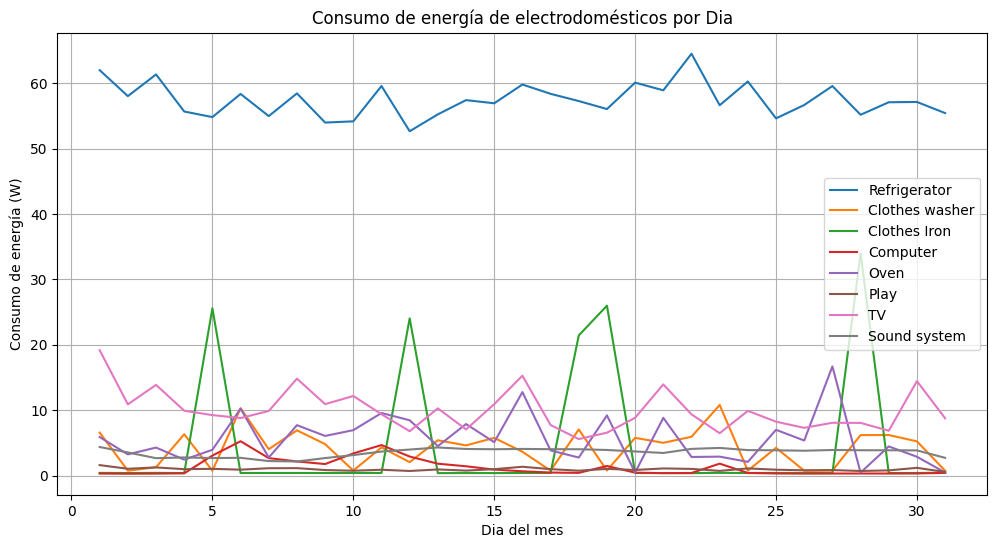

In [464]:
import matplotlib.pyplot as plt

# Lista de electrodomésticos
electrodomesticos = ['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system']

# Configuración de la figura y los ejes
plt.figure(figsize=(12, 6))
plt.title('Consumo de energía de electrodomésticos por Dia')
plt.xlabel('Dia del mes')
plt.ylabel('Consumo de energía (W)')

# Iterar sobre cada electrodoméstico y graficar su consumo por hora
for electrodomestico in electrodomesticos:
    consumo_por_hora = data.groupby('Dia')[electrodomestico].mean()
    plt.plot(consumo_por_hora.index, consumo_por_hora, label=electrodomestico)

# Agregar leyenda y mostrar la gráfica
plt.legend()
plt.grid(True)
plt.show()


In [465]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Aplicar función seno a las variables de predicción (y)
variables_prediccion = ['Refrigerator', 'Clothes washer', 'Clothes Iron', 'Computer', 'Oven', 'Play', 'TV', 'Sound system', 'Medidor [W]']
for variable in variables_prediccion:
    data[f'{variable}_seno'] = np.sin(2 * np.pi * data[variable] / 24)

# Dividir los datos en características (X) y etiquetas (y)
X = data[['Mes', 'Dia', 'Hora', 'Minuto', 'Medidor [W]_seno','Dia_semana_Friday', 'Dia_semana_Monday',
       'Dia_semana_Saturday', 'Dia_semana_Sunday', 'Dia_semana_Thursday',
       'Dia_semana_Tuesday', 'Dia_semana_Wednesday']]
y = data[[f'{variable}_seno' for variable in variables_prediccion if variable != 'Medidor [W]']]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluar el modelo
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("R2 score en entrenamiento:", train_score)
print("R2 score en prueba:", test_score)


R2 score en entrenamiento: 0.018227699757603508
R2 score en prueba: 0.017645187515650404


In [466]:
print(y.columns)

Index(['Refrigerator_seno', 'Clothes washer_seno', 'Clothes Iron_seno',
       'Computer_seno', 'Oven_seno', 'Play_seno', 'TV_seno',
       'Sound system_seno'],
      dtype='object')


In [467]:
from sklearn.metrics import mean_squared_error

# Predecir los valores en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)

print("Error cuadrático medio:", mse)


Error cuadrático medio: 0.0823303921538347


In [468]:
from sklearn.metrics import mean_squared_error

# Predecir los valores en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio por cada columna
mse_por_columna = {}
for i, columna in enumerate(y.columns):
    mse_por_columna[columna] = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])

# Imprimir el MSE por cada columna
for columna, mse_valor in mse_por_columna.items():
    print(f"MSE para {columna}: {mse_valor}")


MSE para Refrigerator_seno: 0.19915732342183143
MSE para Clothes washer_seno: 0.0371292187961409
MSE para Clothes Iron_seno: 0.014287725425078574
MSE para Computer_seno: 0.030412173370305495
MSE para Oven_seno: 0.016552326833031292
MSE para Play_seno: 0.08338230421566371
MSE para TV_seno: 0.11981826345532968
MSE para Sound system_seno: 0.15790380171329413


In [469]:
# Elegir la variable para la cual mostrar los valores (por ejemplo, 'Refrigerator')
variable_elegida = 'Refrigerator'

# Obtener los primeros 5 valores reales y predichos para la variable elegida
primeros_5_valores = pd.DataFrame({
    'Valor Real': y_test[f'{variable_elegida}_seno'].iloc[:10].values,
    'Valor Predicho': y_pred[:10, y.columns.get_loc(f'{variable_elegida}_seno')]
})

# Mostrar los primeros 5 valores reales y predichos
print(f"Valores reales y predichos para la variable '{variable_elegida}' para los primeros 5 datos:")
print(primeros_5_valores)


Valores reales y predichos para la variable 'Refrigerator' para los primeros 5 datos:
   Valor Real  Valor Predicho
0    0.544639        0.143042
1    0.309017        0.170506
2    0.284015        0.164125
3    0.000000        0.157887
4    0.284015        0.121944
5    0.983255        0.133230
6    0.078459        0.150182
7    0.104528        0.150523
8    0.207912        0.115503
9    0.000000        0.120047


In [470]:
# Deshacer la transformación seno en las predicciones
y_pred_inverso = np.arcsin(y_pred)

# Reemplazar los valores predichos que sean negativos por su valor absoluto
y_pred_inverso = np.where(y_pred_inverso < 0, -y_pred_inverso, y_pred_inverso)

# Calcular el error cuadrático medio en la escala original
mse_original = mean_squared_error(np.sin(y_test), np.sin(y_pred_inverso))
print("Error cuadrático medio en la escala original:", mse_original)


Error cuadrático medio en la escala original: 0.06751792277487419


In [471]:
import joblib

# Guardar el modelo
joblib.dump(model, 'modelo_regresion_lineal.h5')

['modelo_regresion_lineal.h5']